In [1]:
# from HHSmotor import *
from bluesky import RunEngine
from bluesky.callbacks import LiveTable, LivePlot
from bluesky.plans import count
from databroker.v2 import temp

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib widget

In [15]:
from ophyd import PVPositioner, Component, Device, EpicsSignal, EpicsSignalRO

class Motor(PVPositioner):
    
    setpoint = Component(EpicsSignal, "speedRef_Rd", write_pv = "speedRef_Wr",  kind="normal")
    readback = Component(EpicsSignalRO, "posTriggered_Rd", kind = "hinted")
    
    smoothed = Component(EpicsSignalRO, "speedExpSmooth", kind = "hinted")
    speedstatus = Component(EpicsSignalRO, "speedStatus", kind = "hinted")
    done = Component(EpicsSignalRO, "ActualBusy", kind = "omitted")
    put_complete = True
    
    acceleration = Component(EpicsSignal, "accel_Rd", write_pv = "accel_Wr", kind = "config")
    deceleration = Component(EpicsSignal, "decel_Rd", write_pv = "decel_Wr", kind = "config")
    
    drvEnable = Component(EpicsSignal, "drvEnable_Rd", write_pv = "drvEnable_Wr", kind = "omitted")
    
    def stage(self):
        self.drvEnable.set(1).wait()
        super().stage()
        
    def unstage(self):
        self.drvEnable.set(0).wait()
        super().unstage()

In [32]:
db = temp()
m1 = Motor("hhs:", name="m1")
m1.wait_for_connection()

RE = RunEngine()

RE.subscribe(db.v1.insert)

RE(count([m1],num=500,delay=0.05)) # minimum delay ~ 0.0021 --> 475 Hz

('bf62967c-9082-4d97-926e-f6258278e229',)

Average Speed: 119 +- 12 rpm


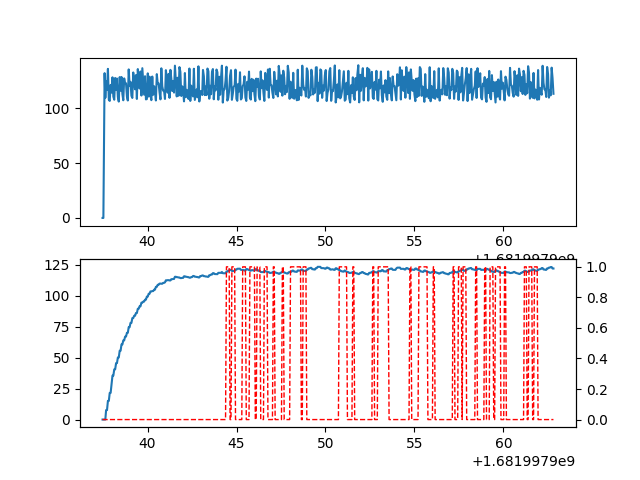

In [33]:
run = db[-1]

speed = run.primary.read().m1_readback
smoothed = run.primary.read().m1_smoothed
speedstatus = run.primary.read().m1_speedstatus

df_speed = speed.to_dataframe()
df_smoothed = smoothed.to_dataframe()
df_status = speedstatus.to_dataframe()


df_speed["m1_readback"] = df_speed["m1_readback"]/10 
df_smoothed["m1_smoothed"] = df_smoothed["m1_smoothed"]/10 

print(f'Average Speed: {int(np.mean(df_speed["m1_readback"]))} +- {int(np.std(df_speed["m1_readback"]))} rpm')
# print(f'Average Speed: {int(np.mean(df_smoothed1["m1_smoothed1"]))} +- {int(np.std(df_smoothed1["m1_smoothed1"]))} rpm')


fig, axs = plt.subplots(2)
axs[0].plot(df_speed)
axs[1].plot(df_smoothed)
ax2 = axs[1].twinx()
ax2.plot(df_status,color="red",linestyle="--", linewidth=1)
plt.show()

In [8]:
# fig, ax = plt.subplots(2,1)
# ax[0].plot(df["time"], df["m1_status_speedFeedback"])
# ax[0].set_ylabel("Speed [rpm]*10")
# ax[0].grid()
# ax[1].plot(df["time"], df["m1_status_posFeedback"])
# ax[1].set_ylabel("Position")
# ax[1].grid()

In [ ]:
# ls = []
# for i in range(0,len(df)-1):
#     if i == len(df):
#         break
#     timedelta = df["time"][i+1]-df["time"][i]
#     freq = 1/(timedelta.total_seconds())
#     ls.append(freq)

# avg_freq = np.mean(ls)
# std_freq = np.std(ls)
# print(f"Average frequency: {int(avg_freq)} +- {int(std_freq)} Hz")

# plt.figure(figsize=(14,4))
# plt.ylabel("Sampling Frequency [Hz]")
# plt.grid()
# plt.plot(ls)

# Measurement Step-by-Step

- (user insert sample)
- 1) Motor 2 ON
- 2) Motor 2 to position 0°
- 3) Motor 2 OFF
- 4) Motor 1 ON
- 5) Motor 1 to position zero
- 6) DVM ON
- 7) Start Motor 1 and start DVM measurement (?synchronized?).
- 8) run at 2 Hz (120rpm) for X turns.
- 9) Motor 1 OFF
- 10) Collect measurement from DVM
- 11) Motor 2 ON
- 12) Motor 2 go to position 90°
- repeat 4-10 for position 90°